# Machine Learning - Absenteeism at Work 

Start this process after you have done Data Exploration to have an understanding of your data

In [1]:
#Dependencies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Step 1:  Load Data 

In [2]:
raw_data=pd.read_excel('Absenteeism_at_work.xls')
raw_data.shape

(740, 21)

# Step 2:  Clean Data

In [3]:
## In our data set if the below features has 0 as the value ,since it is  practically not  an acceptable value, we will replace it with NA
for i in ["Reason for absence","Month of absence","Day of the week","Seasons","Education","ID","Age","Weight","Height","Body mass index", "Absenteeism time in hours" ]:
        raw_data[i] = raw_data[i].replace(0,np.nan)

#Missing values
missing_data = pd.DataFrame(raw_data.isnull().sum())
missing_data = missing_data.rename(columns={0:"NA_sum"})
missing_data["NA_percent"] = (missing_data["NA_sum"]/len(raw_data))*100
missing_data


,NA_sum,NA_percent
ID,0,0.000000
Reason for absence,43,5.810811
Month of absence,3,0.405405
Day of the week,0,0.000000
Seasons,0,0.000000
Transportation expense,0,0.000000
Distance from Residence to Work,0,0.000000
Service time,0,0.000000
Age,0,0.000000
Work load Average/day,0,0.000000


In [4]:
clean_data=raw_data.dropna(how="any")

In [5]:
clean_data.shape

(696, 21)

Also, since we know that weight and height go into the calculation of BMI we will drop both of these features

In [6]:
modified_data=clean_data.drop(["Height", "Weight"], axis=1)
modified_data.shape

(696, 19)

Again, from the Data Exploration we know that "Absenteeism time in hours" has the most outliers. From our analysis we can see that the 

In [7]:
for i in ["Absenteeism time in hours"]:
    # Getting 75 and 25 percentile of variable "i"
    q75, q25 = np.percentile(modified_data[i], [75,25])
    
    # Calculating Interquartile range
    iqr = q75 - q25
    
    # Calculating upper extreme and lower extreme
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
print(f"minimum: {minimum}")
print(f"maximum: {maximum}")

minimum: -7.0
maximum: 17.0


Since the upper is 17 and minimum is -7, we are going to replace anything over 17 to 17 and anything less than -7 to 1.  In looking at the data we found that anything after 16 hours missed it will be for longer periods of time, which could mean that employee is out for long term versus short term.  

In [8]:
# Replacing all the outliers value with maximum and 1 
modified_data.loc[modified_data[i] < minimum,i] = 1
modified_data.loc[modified_data[i] > maximum,i] = maximum

Now we perform One-hot encoding for 
*Day of the week
*Seasons
*Education

# Step 3:  Hot-encoding

In [9]:
day = modified_data.pop('Day of the week')
modified_data['Monday'] = (day == 1)*1.0
modified_data['Tuesday'] = (day == 2)*1.0
modified_data['Wednesday'] = (day == 3)*1.0
modified_data['Thursday'] = (day == 4)*1.0
modified_data['Friday'] = (day ==5)*1.0

In [10]:
#Change season to year
year = modified_data.pop('Seasons')
modified_data['2007'] = (year == 1)*1.0
modified_data['2008'] = (year == 2)*1.0
modified_data['2009'] = (year == 3)*1.0
modified_data['2010'] = (year == 4)*1.0

In [11]:
level = modified_data.pop('Education')
modified_data['Education1'] = (level == 1)*1.0
modified_data['Education2'] = (level == 2)*1.0
modified_data['Education3'] = (level == 3)*1.0
modified_data['Education4'] = (level == 4)*1.0

# Step 4:  Fit Data in to (X,y)

Change data types into categorical and numerical 

In [12]:
#Seperate into two seperate categories to change the datatype
categorical_set = ["Reason for absence","Month of absence","Monday","Tuesday", "Wednesday","Thursday", "Friday",
                   "2007", "2008", "2009", "2010","Disciplinary failure","Education1", "Education2", "Education3",
                   "Education4","Social drinker","Social smoker"]

numerical_set = ["ID","Transportation expense","Distance from Residence to Work","Service time","Age","Work load Average/day ",
                 "Hit target","Son","Pet","Body mass index","Absenteeism time in hours"]

## Converting categorical_set data into category types 
for i in categorical_set :
    modified_data[i] = modified_data[i].astype("category")

for i in numerical_set :
    modified_data[i] = modified_data[i].astype("float64")  

In [13]:
model_data=modified_data
model_data.head()

,ID,Reason for absence,Month of absence,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,...,Thursday,Friday,2007,2008,2009,2010,Education1,Education2,Education3,Education4
0,11.0,26.0,7.0,289.0,36.0,13.0,33.0,239554.0,97.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,23.0,7.0,179.0,51.0,18.0,38.0,239554.0,97.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,7.0,7.0,7.0,279.0,5.0,14.0,39.0,239554.0,97.0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11.0,23.0,7.0,289.0,36.0,13.0,33.0,239554.0,97.0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,3.0,23.0,7.0,179.0,51.0,18.0,38.0,239554.0,97.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now fit the data to test and train the model

In [14]:
X = model_data.drop("Absenteeism time in hours", axis=1)
y = model_data["Absenteeism time in hours"]
print(X.shape, y.shape)

(696, 28) (696,)


In [15]:
feature_names=list(X.columns)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 5: Normalize Data Using Standard Scaler (Optional)

In [ ]:
#from sklearn.preprocessing import StandardScaler

#X_scaler = StandardScaler().fit(X_train)

#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

#scalarX= MinMaxScaler().fit(X_train)

#X_train_scaled = scalarX.transform(X_train)
#X_test_scaled = scalarX.transform(X_test)

In [ ]:
#train_stats = X_train.describe()
#train_stats=train_stats.transpose()

In [ ]:
#def norm(i):
#  return (i - train_stats['mean']) / train_stats['std']

In [ ]:
#X_train_scaled= norm(X_train)
#X_test_scaled = norm(X_test)

# Step 6:  Linear Regression (Attribute Performance Model 1)

This will give you an idea on how your attributes are performing

In [17]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()

In [18]:
model1.fit(X_train, y_train)

# Use our model to predict a value
y_predicted = model1.predict(X_test)
y_predicted = np.round_(y_predicted,0)

In [19]:
# Score the prediction with mse and r2
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R squared (R2 ): {r2}")

Mean Squared Error (MSE): 14.028571428571428
R squared (R2 ): 0.2603730951836558


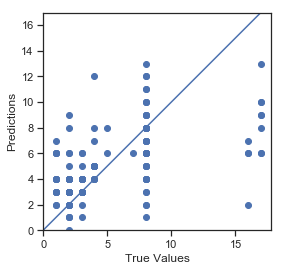

In [20]:
#Plot true values to predictions
plt.scatter(y_test, y_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

We can see that using all attributes is not providing effective results, so we will look at Decision Tree, RandomForest
and GridSearch to see what is the best features we can use

# Step 7: Feature Selection 

# Decision Tree Feature Selection 

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics 

In [22]:
model2= DecisionTreeRegressor(criterion="mse", max_depth=5,
                                random_state=0).fit(X, y)

In [31]:
importances=model2.feature_importances_
importances=pd.DataFrame(importances)
importances["feature_name"]=feature_names
importances.sort_values(by=0, ascending=False)

,0,feature_name
1,0.614273,Reason for absence
4,0.068997,Distance from Residence to Work
11,0.066198,Social drinker
3,0.063474,Transportation expense
8,0.026680,Hit target
16,0.026109,Tuesday
0,0.024976,ID
18,0.023814,Thursday
6,0.022094,Age
7,0.020386,Work load Average/day


# RandomForest Feature Selection 

In [24]:
from sklearn.ensemble import RandomForestRegressor
model3= RandomForestRegressor(n_estimators=100)

C:\Users\aruba\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:
model3.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
importances2=model3.feature_importances_
importances2=pd.DataFrame(importances2)
importances2["feature_name"]=feature_names
importances.sort_values(by=0, ascending=False)

,0,feature_name
1,0.614273,Reason for absence
4,0.068997,Distance from Residence to Work
11,0.066198,Social drinker
3,0.063474,Transportation expense
8,0.026680,Hit target
16,0.026109,Tuesday
0,0.024976,ID
18,0.023814,Thursday
6,0.022094,Age
7,0.020386,Work load Average/day


Both Regressors have come up with the same calculations.  Given these calculations we will only use the attributes 
that have a value.  We will delete the following features. 

In [38]:
Xn = model_data.drop(["Absenteeism time in hours", "Social smoker", "Pet", "Monday", "Disciplinary failure", "Service time",
                     "Month of absence", "Friday", "2007", "2008", "2009", "2010", "Education2", "Education3",
                     "Education4"], axis=1)
yn = model_data["Absenteeism time in hours"]
print(Xn.shape, yn.shape)

(696, 14) (696,)


# Step 8:  Run Models With Modified Data

# Fit Data in to (Xn,yn)

In [39]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.20, random_state=42)

# Linear Regression - Model 1

In [45]:
model1.fit(Xn_train, yn_train)

# Use our model to predict a value
yn1_predicted = model1.predict(Xn_test)
yn1_predicted = np.round_(yn1_predicted,0)

In [46]:
mse = mean_squared_error(yn_test, yn1_predicted)
r2 = r2_score(yn_test, yn1_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R squared (R2 ): {r2}")

Mean Squared Error (MSE): 13.585714285714285
R squared (R2 ): 0.28372180602816366


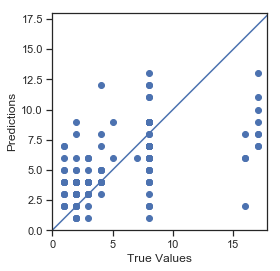

In [47]:
#Plot true values to predictions
plt.scatter(yn_test, yn1_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

# DecisionTree - Model 2

In [48]:
model2.fit(Xn_train, yn_train)

# Use our model to predict a value
yn2_predicted = model2.predict(Xn_test)

# Score the prediction with mse and r2
mse = mean_squared_error(yn_test, yn2_predicted)
r2 = r2_score(yn_test, yn2_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 11.454740285260158
R-squared (R2 ): 0.3960729254721548


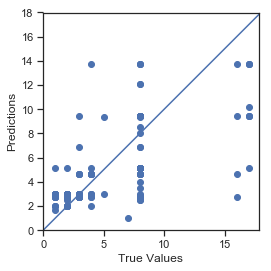

In [49]:
#Plot true values to predictions
plt.scatter(yn_test, yn2_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

# Random Forest Model 3 (n_estimators=100)

In [50]:
model3.fit(Xn_train, yn_train)

# Use our model to predict a value
yn3_predicted = model3.predict(Xn_test)

# Score the prediction with mse and r2
mse = mean_squared_error(yn_test, yn3_predicted)
r2 = r2_score(yn_test, yn3_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 10.22361237804265
R-squared (R2 ): 0.46098155341653513


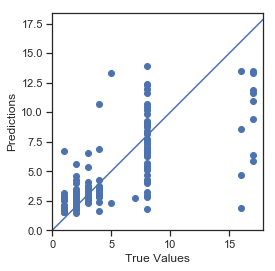

In [51]:
#Plot true values to predictions
plt.scatter(yn_test, yn3_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

# Regression with Keras Model 4

In [118]:
model4 = Sequential()
model4.add(Dense(500, input_dim=14, activation= "relu"))
model4.add(Dense(300, activation= "relu"))
model4.add(Dense(100, activation= "relu"))
model4.add(Dense(50, activation= "relu"))
model4.add(Dense(1))

In [119]:
model4.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model4.fit(Xn_train, yn_train, epochs=500)

Epoch 1/500
556/556 [==============================] - 7s 12ms/step - loss: 26589461.5316 - mean_squared_error: 26589461.5316
Epoch 2/500
556/556 [==============================] - 0s 775us/step - loss: 68459.5899 - mean_squared_error: 68459.5899
Epoch 3/500
556/556 [==============================] - 0s 806us/step - loss: 12391.4349 - mean_squared_error: 12391.4349
Epoch 4/500
556/556 [==============================] - 0s 833us/step - loss: 2041.7507 - mean_squared_error: 2041.7507
Epoch 5/500
556/556 [==============================] - 0s 770us/step - loss: 247.2289 - mean_squared_error: 247.2289
Epoch 6/500
556/556 [==============================] - 0s 738us/step - loss: 80.3324 - mean_squared_error: 80.3324
Epoch 7/500
556/556 [==============================] - 0s 779us/step - loss: 38.2858 - mean_squared_error: 38.2858
Epoch 8/500
556/556 [==============================] - 0s 860us/step - loss: 24.8874 - mean_squared_error: 24.8874
Epoch 9/500
556/556 [==============================

556/556 [==============================] - 0s 770us/step - loss: 183.7205 - mean_squared_error: 183.7205
Epoch 70/500
556/556 [==============================] - 0s 880us/step - loss: 1416.3362 - mean_squared_error: 1416.3362
Epoch 71/500
556/556 [==============================] - 0s 799us/step - loss: 3820.3137 - mean_squared_error: 3820.3137
Epoch 72/500
556/556 [==============================] - 0s 828us/step - loss: 11181.6117 - mean_squared_error: 11181.6117
Epoch 73/500
556/556 [==============================] - 0s 887us/step - loss: 3442.8185 - mean_squared_error: 3442.8185
Epoch 74/500
556/556 [==============================] - 0s 840us/step - loss: 17034.4681 - mean_squared_error: 17034.4681
Epoch 75/500
556/556 [==============================] - 0s 851us/step - loss: 3313.6677 - mean_squared_error: 3313.6677
Epoch 76/500
556/556 [==============================] - 0s 824us/step - loss: 143.6894 - mean_squared_error: 143.68940s - loss: 161.5367 - mean_squared_error: 16
Epoch 77/

556/556 [==============================] - 1s 921us/step - loss: 521.5619 - mean_squared_error: 521.5619
Epoch 137/500
556/556 [==============================] - 1s 988us/step - loss: 177.3869 - mean_squared_error: 177.3869
Epoch 138/500
556/556 [==============================] - 1s 1ms/step - loss: 419.6998 - mean_squared_error: 419.6998
Epoch 139/500
556/556 [==============================] - 1s 1ms/step - loss: 2547.8333 - mean_squared_error: 2547.8333
Epoch 140/500
556/556 [==============================] - 1s 912us/step - loss: 196.8722 - mean_squared_error: 196.8722
Epoch 141/500
556/556 [==============================] - 1s 975us/step - loss: 6644.4944 - mean_squared_error: 6644.4944
Epoch 142/500
556/556 [==============================] - 1s 998us/step - loss: 239396.3505 - mean_squared_error: 239396.3505
Epoch 143/500
556/556 [==============================] - 0s 882us/step - loss: 47467.8544 - mean_squared_error: 47467.8544
Epoch 144/500
556/556 [=============================

556/556 [==============================] - 0s 781us/step - loss: 20.8514 - mean_squared_error: 20.8514
Epoch 204/500
556/556 [==============================] - 0s 847us/step - loss: 30.0251 - mean_squared_error: 30.0251
Epoch 205/500
556/556 [==============================] - 0s 896us/step - loss: 30.4503 - mean_squared_error: 30.4503
Epoch 206/500
556/556 [==============================] - 1s 962us/step - loss: 29.6699 - mean_squared_error: 29.6699
Epoch 207/500
556/556 [==============================] - 1s 937us/step - loss: 22.0540 - mean_squared_error: 22.0540
Epoch 208/500
556/556 [==============================] - 0s 775us/step - loss: 22.5376 - mean_squared_error: 22.5376
Epoch 209/500
556/556 [==============================] - 0s 896us/step - loss: 33.3372 - mean_squared_error: 33.3372
Epoch 210/500
556/556 [==============================] - 1s 982us/step - loss: 21.3421 - mean_squared_error: 21.3421
Epoch 211/500
556/556 [==============================] - 1s 941us/step - loss:

556/556 [==============================] - 0s 874us/step - loss: 44.5081 - mean_squared_error: 44.5081
Epoch 273/500
556/556 [==============================] - 0s 864us/step - loss: 47.7790 - mean_squared_error: 47.7790
Epoch 274/500
556/556 [==============================] - 1s 1ms/step - loss: 67.0663 - mean_squared_error: 67.0663
Epoch 275/500
556/556 [==============================] - 0s 846us/step - loss: 65.2763 - mean_squared_error: 65.2763
Epoch 276/500
556/556 [==============================] - 0s 885us/step - loss: 35.5061 - mean_squared_error: 35.5061
Epoch 277/500
556/556 [==============================] - 0s 734us/step - loss: 102.4355 - mean_squared_error: 102.4355
Epoch 278/500
556/556 [==============================] - 0s 797us/step - loss: 44.5968 - mean_squared_error: 44.5968
Epoch 279/500
556/556 [==============================] - 0s 867us/step - loss: 43.8868 - mean_squared_error: 43.8868
Epoch 280/500
556/556 [==============================] - 0s 864us/step - loss:

556/556 [==============================] - 0s 819us/step - loss: 515.2916 - mean_squared_error: 515.2916
Epoch 340/500
556/556 [==============================] - 0s 748us/step - loss: 559.9545 - mean_squared_error: 559.9545
Epoch 341/500
556/556 [==============================] - 0s 765us/step - loss: 270.3762 - mean_squared_error: 270.3762
Epoch 342/500
556/556 [==============================] - 0s 864us/step - loss: 69.1751 - mean_squared_error: 69.1751
Epoch 343/500
556/556 [==============================] - 0s 849us/step - loss: 44.0385 - mean_squared_error: 44.0385
Epoch 344/500
556/556 [==============================] - 0s 820us/step - loss: 64.4014 - mean_squared_error: 64.4014
Epoch 345/500
556/556 [==============================] - 0s 808us/step - loss: 32.7826 - mean_squared_error: 32.7826
Epoch 346/500
556/556 [==============================] - 1s 939us/step - loss: 59.1872 - mean_squared_error: 59.1872
Epoch 347/500
556/556 [==============================] - 0s 828us/step -

556/556 [==============================] - 0s 815us/step - loss: 166.0423 - mean_squared_error: 166.0423
Epoch 408/500
556/556 [==============================] - 0s 772us/step - loss: 45.7739 - mean_squared_error: 45.7739
Epoch 409/500
556/556 [==============================] - 0s 811us/step - loss: 45.9091 - mean_squared_error: 45.9091
Epoch 410/500
556/556 [==============================] - 1s 909us/step - loss: 79.9884 - mean_squared_error: 79.9884
Epoch 411/500
556/556 [==============================] - 0s 835us/step - loss: 140.2414 - mean_squared_error: 140.2414
Epoch 412/500
556/556 [==============================] - 1s 988us/step - loss: 42.4760 - mean_squared_error: 42.4760
Epoch 413/500
556/556 [==============================] - 1s 901us/step - loss: 62.4693 - mean_squared_error: 62.4693
Epoch 414/500
556/556 [==============================] - 0s 891us/step - loss: 86.5625 - mean_squared_error: 86.5625
Epoch 415/500
556/556 [==============================] - 1s 991us/step - l

556/556 [==============================] - 1s 916us/step - loss: 23.6160 - mean_squared_error: 23.6160
Epoch 476/500
556/556 [==============================] - 0s 871us/step - loss: 41.0790 - mean_squared_error: 41.0790
Epoch 477/500
556/556 [==============================] - 0s 869us/step - loss: 26.1511 - mean_squared_error: 26.1511
Epoch 478/500
556/556 [==============================] - 1s 925us/step - loss: 21.5503 - mean_squared_error: 21.5503
Epoch 479/500
556/556 [==============================] - 0s 846us/step - loss: 50.5798 - mean_squared_error: 50.57980s - loss: 49.6131 - mean_squared_error: 49.61
Epoch 480/500
556/556 [==============================] - 1s 982us/step - loss: 31.4605 - mean_squared_error: 31.46050s - loss: 39.1054 - mean_squared_erro
Epoch 481/500
556/556 [==============================] - 0s 828us/step - loss: 23.9519 - mean_squared_error: 23.9519
Epoch 482/500
556/556 [==============================] - 0s 898us/step - loss: 24.3306 - mean_squared_error: 24

In [120]:
pred_train= model4.predict(Xn_train)
print(np.sqrt(mean_squared_error(yn_train,pred_train)))

pred= model4.predict(Xn_test)
print(np.sqrt(mean_squared_error(yn_test,pred)))

7.121770725227861
7.088438534008857


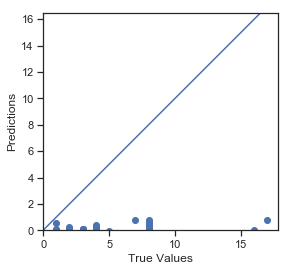

In [121]:
#Plot true values to predictions
plt.scatter(yn_test, pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])